In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
import joblib

import datetime

# Train
size = 'demo'
type_ = 'train'

X_train_file_path = f'./files/numpy/X_{type_}_{size}.npy'
y_train_file_path = f'./files/numpy/y_{type_}_{size}.npy'

X_train = np.load(X_train_file_path)
y_train = np.load(y_train_file_path)

# Validation 
size = 'demo'
type_ = 'validation'

X_val_file_path = f'./files/numpy/X_{type_}_{size}.npy'
y_val_file_path = f'./files/numpy/y_{type_}_{size}.npy'

X_val = np.load(X_val_file_path)
y_val = np.load(y_val_file_path)


print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(176295, 100)
(117052, 100)
(176295,)
(117052,)


In [3]:
# # Normalize the input data
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_val = scaler_X.transform(X_val)

# # Normalize the target data
# Initialize the MinMaxScaler for the target values
# scaler = MinMaxScaler(feature_range=(0, 1))
# y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()

# # Save the scalers
# joblib.dump(scaler_X, './files/models/scaler_X.pkl')
# joblib.dump(scaler_y, './files/models/scaler_y.pkl')

In [9]:
# Define the model
model = Sequential([
    tf.keras.Input(shape=(X_val.shape[1],)),

    Dense(128, activation='relu'),
    # BatchNormalization(),
    Dropout(0.4),  # Adding Dropout layer after the first Dense layer
    Dense(64, activation='relu'),
    # BatchNormalization(),
    Dropout(0.4),  # Adding Dropout layer after the second Dense layer
    Dense(32, activation='relu'),
    # BatchNormalization(),
    Dropout(0.4),  # Adding Dropout layer after the third Dense layer
    
    Dense(1, activation='linear')
])

# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape']) #'mse',


In [10]:
# Prepare TensorBoard callback
log_dir = "files/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Train the model
num_epochs = 5
batch_size = 32
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    
                    callbacks=[tensorboard_callback, TqdmCallback(verbose=1),  early_stop], #, reduce_lr,
                    verbose=2)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5
5510/5510 - 98s - loss: 272.0204 - mae: 12.8459 - mape: 168.6527 - val_loss: 279.2699 - val_mae: 12.3032 - val_mape: 133.0734 - 98s/epoch - 18ms/step
Epoch 2/5
5510/5510 - 55s - loss: 248.4514 - mae: 12.6314 - mape: 177.5860 - val_loss: 263.5451 - val_mae: 12.4201 - val_mape: 152.8604 - 55s/epoch - 10ms/step
Epoch 3/5
5510/5510 - 61s - loss: 243.3369 - mae: 12.5557 - mape: 178.6617 - val_loss: 263.3555 - val_mae: 12.4018 - val_mape: 152.3278 - 61s/epoch - 11ms/step
Epoch 4/5
5510/5510 - 54s - loss: 240.8038 - mae: 12.5033 - mape: 178.1787 - val_loss: 262.0794 - val_mae: 12.4483 - val_mape: 155.9074 - 54s/epoch - 10ms/step
Epoch 5/5
5510/5510 - 45s - loss: 239.1174 - mae: 12.4621 - mape: 177.5282 - val_loss: 261.9044 - val_mae: 12.4956 - val_mape: 158.1167 - 45s/epoch - 8ms/step


In [8]:
pd.DataFrame(history.history)

,loss,mae,mape,val_loss,val_mae,val_mape
0,262.133606,12.948009,182.738693,251.626083,12.811975,182.658371
1,248.605011,12.959699,193.389511,249.486130,12.882117,187.927139
2,248.251053,13.018171,196.527939,249.092133,12.951787,191.884750
3,251.800812,13.030274,197.045639,249.323120,12.903367,189.097397
4,248.307037,13.025889,196.896606,249.034103,12.974910,193.004807
5,248.587265,13.038318,197.367691,248.980499,13.002253,194.352982
6,248.607666,13.039159,197.286316,248.971130,13.091493,198.755188
7,248.892029,13.050874,197.780396,249.011459,12.986041,193.548355
8,248.622620,13.044468,197.511642,248.973999,13.006957,194.573303
9,248.685150,13.047130,197.623398,249.016296,12.983844,193.440826


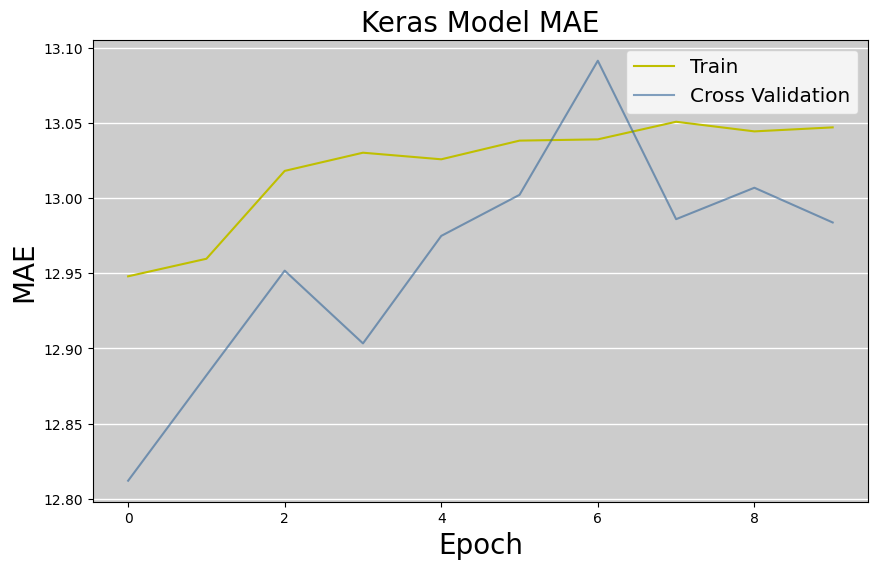

In [4]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mae'], color='y')
plt.plot(history.history['val_mae'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model MAE',size=20)
plt.ylabel('MAE',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

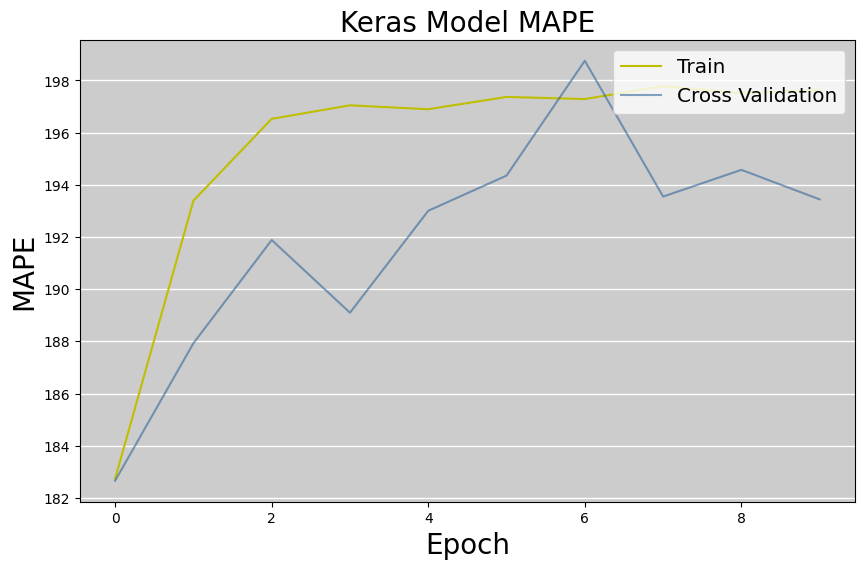

In [5]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mape'], color='y')
plt.plot(history.history['val_mape'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model MAPE',size=20)
plt.ylabel('MAPE',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

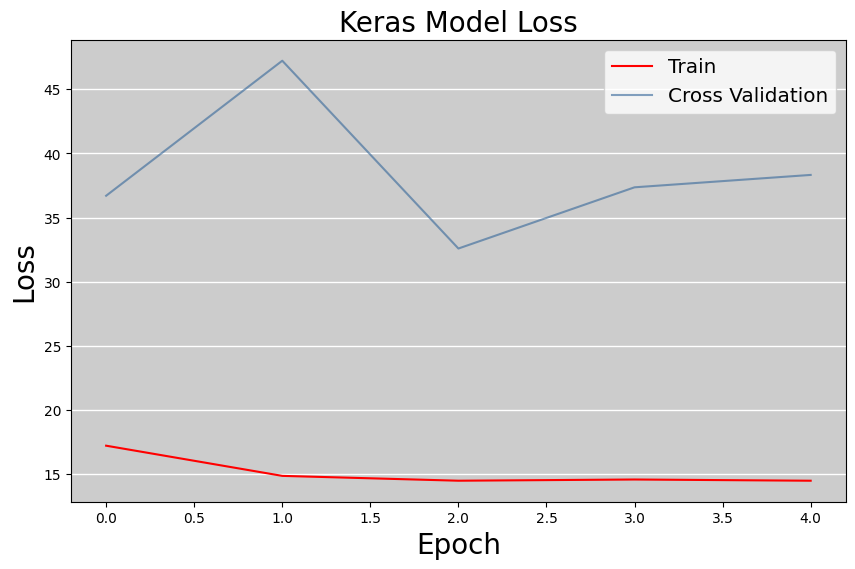

In [35]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model Loss',size=20)
plt.ylabel('Loss',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

In [8]:
# Evaluate the model
train_loss, train_mse,train_mae,train_acc = model.evaluate(X_train, y_train, verbose=1)
test_loss, test_mse,test_mae,test_acc = model.evaluate(X_val, y_val, verbose=1)

5510/5510 [==============================] - 19s 3ms/step - loss: 248.6087 - mae: 13.0449 - mape: 197.5219


ValueError: not enough values to unpack (expected 4, got 3)

In [11]:
# Save the 
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_file_path = f'./files/models/model_{now}.h5py'
print(model_file_path)
model.save(model_file_path)

./files/models/model_20240719-221352.h5py
INFO:tensorflow:Assets written to: ./files/models/model_20240719-221352.h5py\assets


INFO:tensorflow:Assets written to: ./files/models/model_20240719-221352.h5py\assets
